In [2]:
from web3 import Web3
import json 
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv
import os 

load_dotenv()

api_key = os.getenv('ALCHEMY_API_KEY')
w3 = Web3(Web3.HTTPProvider(f'https://eth-mainnet.g.alchemy.com/v2/{api_key}'))


Loading some of the contracts here:

In [5]:
# initializing GHO contract

gho_contract = {}
gho_contract["address"] = Web3.toChecksumAddress("0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f")
with open("abis/gho_abi.json") as f:
    data = json.load(f)
    gho_contract["abi"] = data

gho = w3.eth.contract(address=gho_contract["address"], abi=gho_contract["abi"])

v3_pool_contract = {}
v3_pool_contract["address"] = Web3.toChecksumAddress("0x87870Bca3F3fD6335C3F4ce8392D69350B4fA4E2")
with open("abis/ethereum_v3_pool.json") as f:
    data = json.load(f)
    v3_pool_contract["abi"] = data

v3_pool = w3.eth.contract(
    address=v3_pool_contract["address"], abi=v3_pool_contract["abi"]
)

variable_debt_gho_contract = {}
variable_debt_gho_contract["address"] = Web3.toChecksumAddress("0x786dBff3f1292ae8F92ea68Cf93c30b34B1ed04B")
with open("abis/gho_variable_debt_abi.json") as f:
    data = json.load(f)
    variable_debt_gho_contract["abi"] = data

variable_debt_gho = w3.eth.contract(
    address=variable_debt_gho_contract["address"], abi=variable_debt_gho_contract["abi"]
)

with open("abis/gho_interest_rate_strategy_abi.json") as f:
    data = json.load(f)

    GHOinterestRateStrategy = w3.eth.contract(
        address="0x00524e8E4C5FD2b8D8aa1226fA16b39Cad69B8A0", 
        abi=data
    )

with open("abis/AaveProtocolDataProvider_abi.json") as f:
    data = json.load(f)
    aaveprotocoldataprovider = w3.eth.contract(address = "0x7B4EB56E7CD4b454BA8ff71E4518426369a138a3",
                                               abi=data)

with open("abis/UiPoolDataProviderV3_abi.json") as f:
    data = json.load(f)
    UiPoolDataProviderV3 = w3.eth.contract(address = "0x91c0eA31b49B69Ea18607702c5d9aC360bf3dE7d",
                                               abi=data)

### Basic ERC20 data 

In [6]:
gho_decimals = gho.functions.decimals().call()
gho_totalSupply = gho.functions.totalSupply().call() / (10**gho_decimals)
print(f'GHO has {gho_decimals} decimals')
print(f"GHO total supply is: {'{0:,.1f}'.format(gho_totalSupply)}")

GHO has 18 decimals
GHO total supply is: 34,655,954.1


In [7]:
user = "0xE831C8903de820137c13681E78A5780afDdf7697"
gho_balance = gho.functions.balanceOf(user).call() / (10**gho_decimals)
print(f"{user}'s balance: {'{0:,.0f}'.format(gho_balance)}")

0xE831C8903de820137c13681E78A5780afDdf7697's balance: 3,175,760


### GHO specific data

Facilitators

In [8]:
getFacilitatorsList = gho.functions.getFacilitatorsList().call()
getFacilitatorsList

['0x00907f9921424583e7ffBfEdf84F92B7B2Be4977',
 '0xb639D208Bcf0589D54FaC24E655C79EC529762B8']

In [9]:
bucketCapacity, bucketLevel, Name = gho.functions.getFacilitator(getFacilitatorsList[0]).call()
print(Name)
print(f'bucketCapacity: {bucketCapacity/10**gho_decimals/10**6}m')
print(f'bucketLevel: {round(bucketLevel/10**gho_decimals/10**6,1)}m')

Aave V3 Ethereum Pool
bucketCapacity: 100.0m
bucketLevel: 34.7m


In [10]:
bucketCapacity, bucketLevel = gho.functions.getFacilitatorBucket("0x00907f9921424583e7ffBfEdf84F92B7B2Be4977").call()

### Event Logs

In [11]:
# Transfer event signature
transfer_event_signature = w3.sha3(text="Transfer(address,address,uint256)").hex()

fromBlock = 17698470 # GHO was deployed here
toBlock = w3.eth.blockNumber # get all blocks  
blockRangeSize = 100000      # we search 100k blocks at a time 

events = []
currentBlock = fromBlock

# iterate through 100k block chunks to pull all gho events
# note: we are doing that because the number of logs is too much for
# the node to handle 
while currentBlock < toBlock:
    
    endBlock = min(currentBlock + blockRangeSize, toBlock)
    print(f'Processing blocks {currentBlock} to {endBlock}')

    event_filter = {
        'fromBlock': currentBlock,
        'toBlock': endBlock,
        'address': gho.address,
        'topics': [transfer_event_signature]
    }

    logs = w3.eth.getLogs(event_filter)

    for log in logs:
        event = gho.events.Transfer().processReceipt({'logs': [log]})
        event_data = dict(event[0]['args'])  # Convert AttributeDict to dict
        event_data['blockNumber'] = log['blockNumber']  # Add block number
        events.append(event_data)

    currentBlock = endBlock + 1


Processing blocks 17698470 to 17798470
Processing blocks 17798471 to 17898471
Processing blocks 17898472 to 17998472
Processing blocks 17998473 to 18098473
Processing blocks 18098474 to 18198474
Processing blocks 18198475 to 18298475
Processing blocks 18298476 to 18398476
Processing blocks 18398477 to 18498477
Processing blocks 18498478 to 18598478
Processing blocks 18598479 to 18698479
Processing blocks 18698480 to 18798480
Processing blocks 18798481 to 18898481
Processing blocks 18898482 to 18989005


In [12]:
# Convert events to DataFrame
transfers = [{'from': e['from'], 'to': e['to'], 'value': e['value'], 'blockNumber': e['blockNumber']} for e in events]
transfers_df = pd.DataFrame(transfers)

In [13]:
transfers_df.groupby('from').count().reset_index().sort_values(['value']).head(5)

,from,to,value,blockNumber
1756,0xD18872DFb160B93DeD8FcC890E78f4b7df0D22A3,1,1,1
1909,0xF41c607AD9A8115DB4810eC0bc83C12C8B190d9D,1,1,1
742,0x4c32B885386645591A5975B65a5405Ca7B14A68C,1,1,1
743,0x4cAc491cA43c8fBc62FB598Df51b7dC27592f298,1,1,1
744,0x4cE674a52f6668C3C3cC263Bc16EeE54d74E2C96,1,1,1


In [14]:
address_to_track = '0x383E7ACD889bF57b0D79A584009Cb570534aB518' # uniswap V3 GHO-USDT pool

address_transfers = transfers_df[(transfers_df['to'] == address_to_track) | (transfers_df['from'] == address_to_track)].copy()
address_transfers['balance_change'] = address_transfers.apply(lambda row: row['value'] if row['to'] == address_to_track else -row['value'], axis=1)
address_transfers['rolling_balance'] = address_transfers['balance_change'].cumsum() / 10**gho_decimals
address_transfers[['from','to','value','blockNumber','balance_change', 'rolling_balance']].tail(5)
# most recent 5 transfers

,from,to,value,blockNumber,balance_change,rolling_balance
27067,0xDEF171Fe48CF0115B1d80b88dc8eAB59176FEe57,0x383E7ACD889bF57b0D79A584009Cb570534aB518,1500000000000000000000,18985774,1500000000000000000000,264654.611024
27070,0x383E7ACD889bF57b0D79A584009Cb570534aB518,0x1111111254EEB25477B68fb85Ed929f73A960582,253716360675147404146,18986630,-253716360675147404146,264400.894663
27074,0x9008D19f58AAbD9eD0D60971565AA8510560ab41,0x383E7ACD889bF57b0D79A584009Cb570534aB518,31418628481368156284,18986862,31418628481368156284,264432.313292
27076,0x7374E5a0aa341f8b9c1DF17BBd3ea156a5bfB927,0x383E7ACD889bF57b0D79A584009Cb570534aB518,480664965787662334223,18987292,480664965787662334223,264912.978258
27084,0x9008D19f58AAbD9eD0D60971565AA8510560ab41,0x383E7ACD889bF57b0D79A584009Cb570534aB518,1582012563265845048754,18987683,1582012563265845048754,266494.990821


Plotting our data

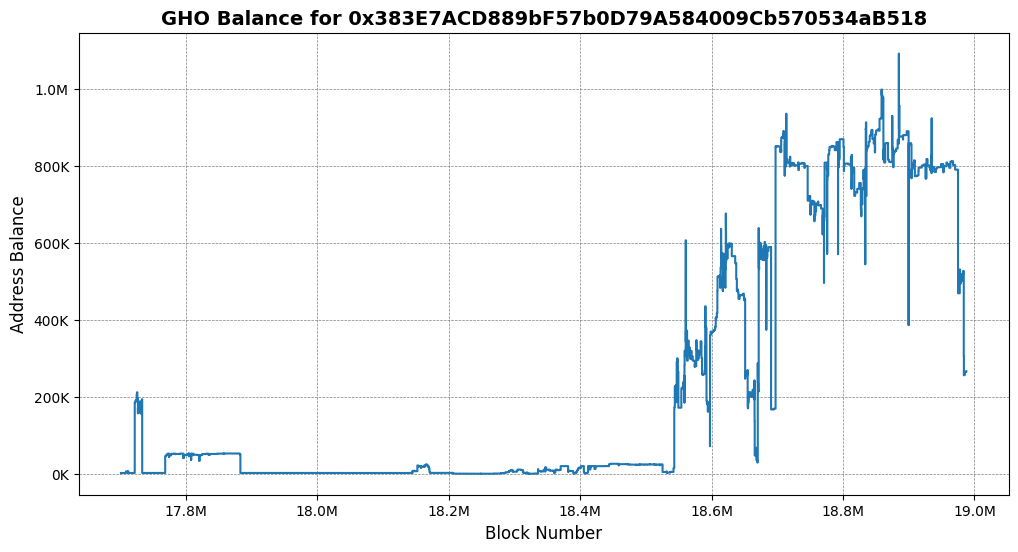

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function to format the balance in thousands
def dynamic_formatter(x, pos):
    if x >= 1e6:  # If the value is in the millions
        return '%1.1fM' % (x * 1e-6)
    else:  # If the value is less than a million (in thousands)
        return '%1.0fK' % (x * 1e-3)

def format_in_millions(x, pos):
    return '%1.1fM' % (x * 1e-6)


# Ensure your DataFrame is sorted by blockNumber
address_transfers = address_transfers.sort_values(by='blockNumber')

# Plotting
plt.figure(figsize=(12, 6))

# Using step function for discrete changes
plt.step(address_transfers['blockNumber'], address_transfers['rolling_balance'], where='post')

# Set the title and labels
plt.title('GHO Balance for {}'.format(address_to_track), fontsize=14, fontweight='bold')
plt.xlabel('Block Number', fontsize=12)
plt.ylabel('Address Balance', fontsize=12)

formatter = ticker.FuncFormatter(dynamic_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
x_formatter = ticker.FuncFormatter(format_in_millions)
plt.gca().xaxis.set_major_formatter(x_formatter)

# Improve grid visibility and style
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Show the plot with enhanced aesthetics
plt.show()


- https://etherscan.io/address/0x7B4EB56E7CD4b454BA8ff71E4518426369a138a3#readContract 
- https://docs.aave.com/developers/core-contracts/aaveprotocoldataprovider#getreservecaps

#### Looking at the UiPoolDataProviderV3 contract 

In [16]:
reserves_data_raw = UiPoolDataProviderV3.functions.getReservesData("0x2f39d218133AFaB8F2B819B1066c7E434Ad94E9e").call()
extracted_elements = [[z[i] for i in [0,1,2,3,4,15,16,28,13,14,46]] for z in reserves_data_raw[0]]

reserves_df = pd.DataFrame(extracted_elements, columns=['asset', 'name', 'symbol', 'decimals', 'lt','depositRate', 'borrowRate','price','liquidity_index','variabledebt_index','borrow_cap'])
reserves_df['depositRate'] = reserves_df['depositRate'] / 10**27
reserves_df['borrowRate'] = reserves_df['borrowRate'] / 10**27
reserves_df['lt'] = reserves_df['lt'] / 10**2
reserves_df['price'] = reserves_df['price'] / 10**8
reserves_df

,asset,name,symbol,decimals,lt,depositRate,borrowRate,price,liquidity_index,variabledebt_index,borrow_cap
0,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,Wrapped Ether,WETH,18,80.5,0.012343,0.022544,2621.858544,1018550431475912051407576281,1033645490366614803012958952,1400000
1,0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0,Wrapped liquid staked Ether 2.0,wstETH,18,78.5,0.000025,0.003369,3023.912553,1000525611014820698126294467,1003935490376873248558222326,24000
2,0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599,Wrapped BTC,WBTC,8,73.0,0.000701,0.008826,46217.731917,1001788528120211375654597719,1012281459302237484599298383,28000
3,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,USD Coin,USDC,6,77.0,0.062501,0.076781,1.000062,1036363308629289443611335488,1047237443403449983134773285,1580000000
4,0x6B175474E89094C44Da98b954EedeAC495271d0F,Dai Stablecoin,DAI,18,77.0,0.039916,0.049638,0.999857,1035204880100323183224086123,1048997715422121504698406206,271000000
5,0x514910771AF9Ca656af840dff83E8264EcF986CA,ChainLink Token,LINK,18,53.0,0.000007,0.001164,14.939661,1000430348616074989002695460,1004699530167367210580451421,13000000
6,0x7Fc66500c84A76Ad7e9c93437bFc5Ac33E2DDaE9,Aave Token,AAVE,18,66.0,0.0,0.0,109.883904,1000000000000000000000000000,1000000000000000000000000000,0
7,0xBe9895146f7AF43049ca1c1AE358B0541Ea49704,Coinbase Wrapped Staked ETH,cbETH,18,74.5,0.0001,0.004273,2772.153873,1001469708939444565687626567,1008614293601302769576661707,2400
8,0xdAC17F958D2ee523a2206206994597C13D831ec7,Tether USD,USDT,6,74.0,0.040481,0.049989,1.000390,1038550601494905428510856678,1052362324493087038622640707,750000000
9,0xae78736Cd615f374D3085123A210448E74Fc6393,Rocket Pool ETH,rETH,18,74.5,0.000045,0.002865,2871.268998,1001319136421450886589229421,1010225744841914919116497797,19200


In [18]:
# transfer_event_signature = w3.sha3(text="Transfer(address,address,uint256)").hex()

# event_filter = {
#     'fromBlock': currentBlock,  # GHO deployement block
#     'toBlock': endBlock,        # current block
#     'address': gho.address,   # GHO address
#     'topics': [transfer_event_signature]    # Transfer events
# }

# logs = w3.eth.getLogs(event_filter)



## GHO Collateralization Research

Bonus - if we have time:

How can we find the collateralization of GHO? 

In [20]:
#### Lets find all GHO borrowers

debt_mint_signature = w3.sha3(text="Mint(address,address,uint256,uint256)").hex()

fromBlock = 17698470         # GHO was deployed here
toBlock = w3.eth.blockNumber # get all blocks  

variable_debt_gho_transfer_events = []

event_filter = {
    'fromBlock': fromBlock,
    'toBlock': toBlock,
    'address': variable_debt_gho.address,
    'topics': [transfer_event_signature]
}

logs = w3.eth.getLogs(event_filter)
debt_mints = []
for log in logs:
    event = variable_debt_gho.events.Transfer().processReceipt({'logs': [log]})
    debt_mint = dict(event[0]['args']) 
    debt_mint['blockNumber'] = log['blockNumber']  
    debt_mints.append(debt_mint)

In [21]:
gho_debt_holders = pd.DataFrame(debt_mints)[['to']].drop_duplicates()
# Initialize an empty list to store balances
balances = []

# Iterate over each holder and fetch their balance
for holder in gho_debt_holders['to']:
    holder_balance = variable_debt_gho.functions.balanceOf(Web3.toChecksumAddress(holder)).call()
    balances.append(holder_balance)

# Add the balances as a new column to your DataFrame
gho_debt_holders['balance'] = balances


In [ ]:
gho_debt_holders = gho_debt_holders[gho_debt_holders.balance != 0].copy()
gho_debt_holders = gho_debt_holders.rename(columns={'to': 'addr'})

In [66]:
x = pd.DataFrame()
for addr in tqdm(gho_debt_holders['addr'], desc="Processing addresses"):
    user_data = UiPoolDataProviderV3.functions.getUserReservesData("0x2f39d218133AFaB8F2B819B1066c7E434Ad94E9e",addr).call()
    new_row = pd.DataFrame(user_data[0], columns=['underlyingAsset', 'scaledATokenBalance', 'usageAsCollateralEnabledOnUser', 'stableBorrowRate', 'scaledVariableDebt', 'principalStableDebt', 'stableBorrowLastUpdateTimestamp'])
    new_row['addr'] = addr 
    x = pd.concat([x,new_row])

Processing addresses: 100%|██████████| 965/965 [01:45<00:00,  9.14it/s]


In [100]:
positions = pd.merge(x,
         reserves_df,
         how='left',
         left_on=['underlyingAsset'],
         right_on=['asset'])
positions['aTokenValue'] = positions['scaledATokenBalance'] * positions['liquidity_index'] / 10**27 / 10**positions['decimals'] * positions['price']
positions['debtValue'] = positions['scaledVariableDebt'] * positions['variabledebt_index'] / 10**27 / 10**positions['decimals'] * positions['price']
positions['current_debt'] = positions['scaledVariableDebt'] * positions['variabledebt_index'] / 10**27 / 10**positions['decimals']

pd.merge(
    positions[(positions.symbol == 'GHO')],
    positions[(positions.symbol != 'GHO')&(positions.debtValue>0)].groupby(['addr'])[['debtValue']].sum().reset_index(),
    on='addr')


,underlyingAsset,scaledATokenBalance,usageAsCollateralEnabledOnUser,stableBorrowRate,scaledVariableDebt,principalStableDebt,stableBorrowLastUpdateTimestamp,addr,asset,name,...,depositRate,borrowRate,price,liquidity_index,variabledebt_index,borrow_cap,aTokenValue,debtValue_x,current_debt,debtValue_y
0,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,0,False,0,40598320756585069579093,0,0,0xD3e08A7F2b5AdbA52DBA1f8813F3a5def3A282b3,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,...,0.0,0.0622,1.0,1000000000000000000000000000,1015603768848688696937267416,35000000,0.0,41231.807569,41231.807569,11408.180985
1,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,0,False,0,999999457762704217,0,0,0x9677E256755e1718e7e455B3BF9bce84C6db6B2e,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,...,0.0,0.0622,1.0,1000000000000000000000000000,1015603768848688696937267416,35000000,0.0,1.015603,1.015603,1.044449
2,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,0,False,0,6993485298734604359055,0,0,0xEB52371F5a251E93799A64844A88d3F56872AD00,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,...,0.0,0.0622,1.0,1000000000000000000000000000,1015603768848688696937267416,35000000,0.0,7102.610027,7102.610027,262.962755
3,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,0,False,0,201131721654025276,0,0,0xfeCF38aD9b16D2B7f5f040a534c478d8e6d938bE,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,...,0.0,0.0622,1.0,1000000000000000000000000000,1015603768848688696937267416,35000000,0.0,0.20427,0.20427,1694.725815
4,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,0,False,0,40210773713614899470112,0,0,0x7047e87FaA87d7f3D67086d8B4B3af60cB41c37d,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,...,0.0,0.0622,1.0,1000000000000000000000000000,1015603768848688696937267416,35000000,0.0,40838.213332,40838.213332,18439.718887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,0,False,0,84430399412111402057500,0,0,0x279D439bfC6126e2DB25058c0c7257dDf588bf02,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,...,0.0,0.0622,1.0,1000000000000000000000000000,1015603768848688696937267416,35000000,0.0,85747.831848,85747.831848,112786.481454
375,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,0,False,0,2956804657267545394822,0,0,0x764EF072a36670361cb6ce8D489B7Ec66737b5d1,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,...,0.0,0.0622,1.0,1000000000000000000000000000,1015603768848688696937267416,35000000,0.0,3002.941954,3002.941954,84358.453093
376,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,0,False,0,1755432148587402745412,0,0,0x1bc371d79c5D3DaD6a9C2CE7EF7251C3A956527b,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,...,0.0,0.0622,1.0,1000000000000000000000000000,1015603768848688696937267416,35000000,0.0,1782.823506,1782.823506,2904.729968
377,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,0,False,0,985120518822194216276,0,0,0xe97968CD95b25032e6a538c7708f09F3eC37813B,0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f,Gho Token,...,0.0,0.0622,1.0,1000000000000000000000000000,1015603768848688696937267416,35000000,0.0,1000.492112,1000.492112,192044.540277
